In [6]:
import os
import random
import json
from tqdm import tqdm

source_dir = '/home/jack/Mounts/DiskOne/doggy_cam/datasets/hapa'
yolo_dir = '/home/jack/Mounts/DiskOne/doggy_cam/datasets/dog_objects/yolo'

image_dir = os.path.join(source_dir, 'images')

with open(os.path.join(source_dir, 'coco.json'), 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']

# filter images that have no annotations
image_ids = set()
for annotation in annotations:
    image_ids.add(annotation['image_id'])

# filter images that have no annotations
images = [image for image in images if image['id'] in image_ids]

print(f'Found {len(images)} images with annotations')

Found 127 images with annotations


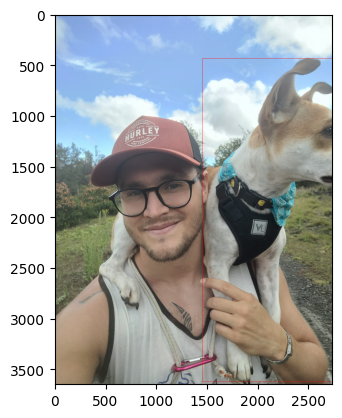

In [8]:
import matplotlib.pyplot as plt
import cv2

image = random.choice(images)

image_path = os.path.join(image_dir, image['file_name'])

annos = [annotation for annotation in annotations if annotation['image_id'] == image['id']]

frame = cv2.imread(image_path)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

for anno in annos:
    bbox = anno['bbox']
    x, y, w, h = bbox
    x, y, w, h = int(x), int(y), int(w), int(h)
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
plt.imshow(frame)

In [9]:
def coco_to_yolo(x1, y1, x2, y2, frame_shape):
    # convert xmin, ymin, xmax, ymax to normalized center pixel xc, xy, width, height
    xc = ((x1 + x2) / 2) / frame_shape[1]
    yc = ((y1 + y2) / 2) / frame_shape[0]
    w = (x2 - x1) / frame_shape[1]
    h = (y2 - y1) / frame_shape[0]
    
    return xc, yc, w, h


def xywh_to_yolo(x, y, w, h, frame_shape):
    return coco_to_yolo(x, y, x + w, y + h, frame_shape)

train = random.sample(images, int(len(images) * 0.8))
images = [x for x in images if x not in train]

test = images

for sett, images in zip(['train', 'test'], [train, test]):
    for image in tqdm(images, desc=sett):
        image_file = os.path.join(source_dir, 'images', image['file_name'])
        new_image_file = os.path.join(yolo_dir, 'images', sett, image['file_name'])
        os.system(f'cp {image_file} {new_image_file}')
        
        image_width = int(image['width'])
        image_height = int(image['height'])
        
        with open(os.path.join(yolo_dir, 'labels', sett, os.path.splitext(image['file_name'])[0] + '.txt'), 'w') as f:
            for annotation in annotations:
                if annotation['image_id'] == image['id']:
                    
                    box = annotation['bbox']
                    xc, yc, width, height = xywh_to_yolo(*box, (image_height, image_width))

                    f.write(f'0 {xc} {yc} {width} {height}\n')

test: 100%|██████████| 26/26 [00:00<00:00, 231.07it/s]
